De beste bron (vlgm):
(1) https://medium.com/analytics-vidhya/analysis-of-stock-price-predictions-using-lstm-models-f993faa524c4

2e beste, zeer uitgebreid met theorie:
(2) https://www.datacamp.com/community/tutorials/lstm-python-stock-market
& (3) https://thinkingneuron.com/predicting-stock-prices-using-deep-learning-lstm-model-in-python/

Research paper LSTM:
https://www.econstor.eu/bitstream/10419/157808/1/886576210.pdf?ref=https://codemonkey.link

# (1)

In [93]:
## Keras is a part of tensor flow! (https://stackoverflow.com/questions/66964492/importerror-cannot-import-name-get-config-from-tensorflow-python-eager-conte)
import tensorflow as tf
from tensorflow import keras
# keras.models.Model
# keras.layers.Dense, keras.layers.Dropout, keras.layers.LSTM, keras.layers.Input, keras.layers.Activation
# keras.optimizers
# keras.callbacks.History

import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import yfinance as yf
from datetime import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import numpy as np

In [94]:
def train_test_split_preparation(new_df, data_set_points, train_split):
    new_df = new_df.iloc[1:]

# Indices of the training data of the model
    train_indices = int(new_df.shape[0] * train_split)
    train_df = new_df[:train_indices]
# Indices of the testing (= remaining) data of the model
    test_df = new_df[train_indices:]
                                               # test_df = test_df.reset_index()        Not necessary?? Date index is good
                                               # test_df = test_df.drop(columns = ['index'])
    
# Calculating the difference for each dataframe
    train_diff = np.diff(train_df.loc[:, ['Adj Close']].values, axis = 0)
    test_diff = np.diff(test_df.loc[:, ['Adj Close']].values, axis = 0)

# 
    X_train = np.array([train_diff[i : i + data_set_points] for i in range(len(train_diff) - data_set_points)])
    Y_train = np.array([train_diff[i + data_set_points] for i in range(len(train_diff) - data_set_points)])

    
    Y_valid = np.array([train_df['Adj Close'][-(int)(len(Y_train)/10):].copy()])

    Y_valid = Y_valid.flatten()
    Y_valid = np.expand_dims(Y_valid, -1)

    X_test = np.array([test_diff[i : i + data_set_points] for i in range(len(test_diff) - data_set_points)])

    Y_test = np.array([test_df['Adj Close'][i + data_set_points] for i in range(len(test_diff) - data_set_points)])


    return X_train, Y_train, X_test, Y_test, test_df

In [95]:
def lstm_model(X_train, y_train, data_set_points):
# Setting of seed (to maintain constant result)
    tf.random.set_seed(20)
    np.random.seed(10)

# Setting-up LSTM model, inputs, and outputs 
    lstm_input = keras.layers.Input(shape=(data_set_points, 1), name='input_for_lstm')
    
    inputs = keras.layers.LSTM(21, name='first_layer', return_sequences = True)(lstm_input)
    inputs = keras.layers.Dropout(0.1, name='first_dropout_layer')(inputs)
    inputs = keras.layers.LSTM(64, name='lstm_1')(inputs) #32
    inputs = keras.layers.Dropout(0.05, name='lstm_dropout_1')(inputs) #Dropout layers to prevent overfitting
    inputs = keras.layers.Dense(64, name='first_dense_layer')(inputs) #32
    inputs = keras.layers.Dense(1, name='dense_layer')(inputs)
    
    output = keras.layers.Activation('linear', name='output')(inputs)

# Running the model
    model = keras.models.Model(inputs=lstm_input, outputs=output)
    adam = keras.optimizers.Adam(lr = 0.002)

    model.compile(optimizer=adam, loss='mse')
    model.fit(x=X_train, y=Y_train, batch_size=15, epochs=25, shuffle=True, validation_split = 0.05)

    return model

In [107]:
def generate_predicted_result_based_on_previous_actual(actual, y_pred): 
    temp_actual = actual[:-1]

# Adding each actual price at time t with the predicted difference to get a predicted price at time t + 1
    new = np.add(temp_actual, y_pred)

    plt.gcf().set_size_inches(15, 10, forward=True)
    plt.title('Plot of real price and predicted price against number of days for test set')
    plt.xlabel('Number of days')
    plt.ylabel('Adjusted Close Price($)')

    plt.plot(actual[1:], label='Actual Price')
    plt.plot(new, label='Predicted Price')

    print(mean_squared_error(actual[1:], new, squared = False))

# Plotting of model  
    plt.legend(['Actual Price', 'Predicted Price'])

    
    plt.show()

[*********************100%***********************]  1 of 1 completed
Epoch 1/25
111/111 [==============================] - 2s 17ms/step - loss: 0.0595 - val_loss: 1.1202
Epoch 2/25
111/111 [==============================] - 1s 9ms/step - loss: 0.0592 - val_loss: 1.1102
Epoch 3/25
111/111 [==============================] - 1s 9ms/step - loss: 0.0595 - val_loss: 1.1243
Epoch 4/25
111/111 [==============================] - 1s 9ms/step - loss: 0.0593 - val_loss: 1.1215
Epoch 5/25
111/111 [==============================] - 1s 9ms/step - loss: 0.0592 - val_loss: 1.1239
Epoch 6/25
111/111 [==============================] - 1s 9ms/step - loss: 0.0589 - val_loss: 1.1109
Epoch 7/25
111/111 [==============================] - 1s 9ms/step - loss: 0.0590 - val_loss: 1.1237
Epoch 8/25
111/111 [==============================] - 1s 9ms/step - loss: 0.0588 - val_loss: 1.1164
Epoch 9/25
111/111 [==============================] - 1s 9ms/step - loss: 0.0591 - val_loss: 1.1210
Epoch 10/25
111/111 [=========

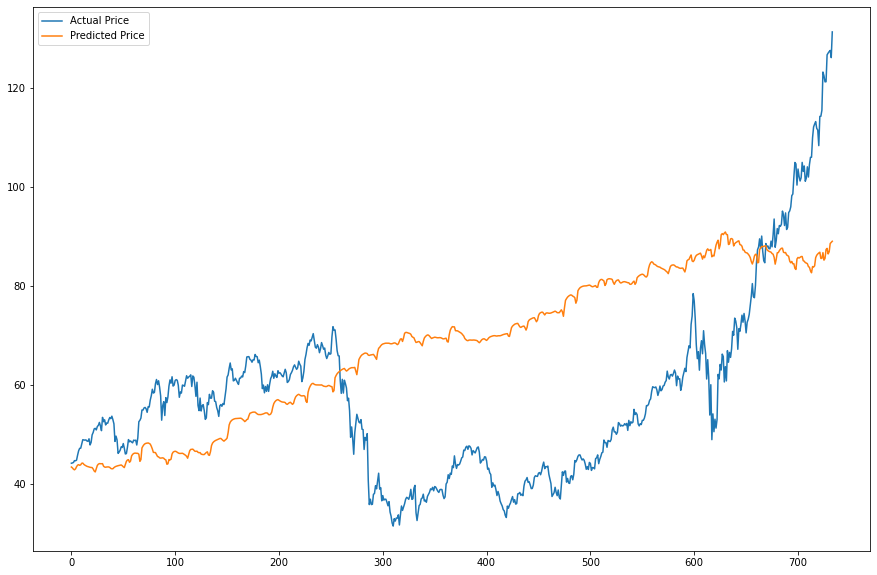

1.7946258625808575


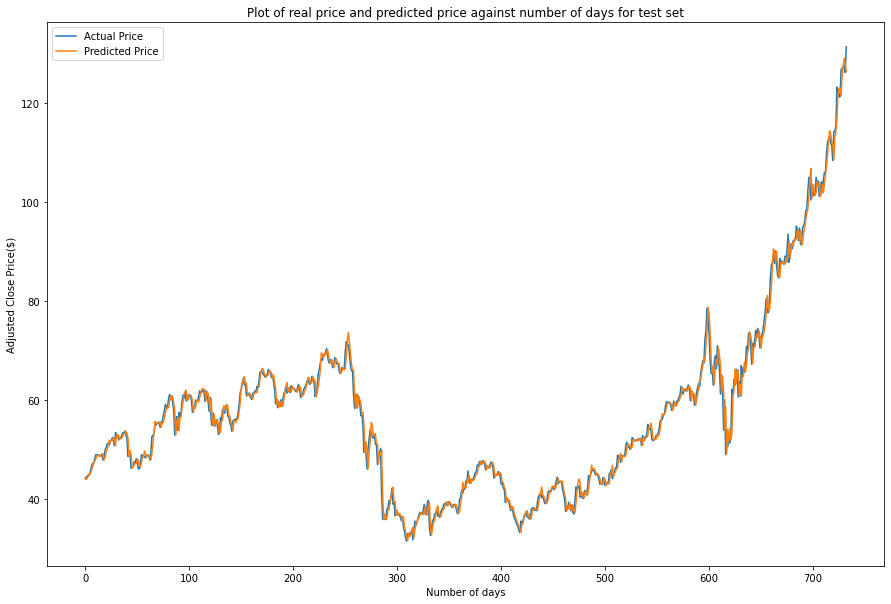

In [114]:
if __name__ == "__main__":
    start_date = datetime(2010, 9, 1)
    end_date = datetime(2020, 8, 31)
    
# DataReader method in the pandas_datareader library
    stock_df = yf.download("NVDA", start_date, end_date)
    new_df = stock_df[['Adj Close']].copy()
    
# Params for data    
    train_split = 0.7 #0.7  
    data_set_points = 21

# Train test split
    X_train, Y_train, X_test, Y_test, test_df = train_test_split_preparation(new_df, data_set_points, train_split)
    
# Training of model
    model = lstm_model(X_train, Y_train, data_set_points)

# prediction of model
    Y_pred = model.predict(X_test)
    Y_pred = Y_pred.flatten()

    # actual represents the test set's actual stock prices
    actual = np.array([test_df['Adj Close'][i + data_set_points].copy() for i in range(len(test_df) - data_set_points)])

    # Prev is the stock price of the point before the prediction, so we can iteratively add the difference
    prev = test_df['Adj Close'][data_set_points - 1]

    # Predictions list
    predictions = []
    predictions.append(prev)

    # Adding difference and appending to the predictions list
    for i in Y_pred:
        prev += i
        predictions.append(prev)

    predictions = np.array(predictions)

   # print(predictions)

# Plotting
    real = plt.plot(actual, label='Actual Price')
    pred = plt.plot(predictions, label='Predictions Price')

    plt.legend(['Actual Price', 'Predicted Price'])
    plt.gcf().set_size_inches(15, 10, forward=True)
    
    plt.show()

    #Use of an algorithm to buy and sell if it exceeds the threshold
    #y_pct_change = buy_sell_trades(actual, predicted)

    generate_predicted_result_based_on_previous_actual(actual, Y_pred)